In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from icevision.all import *

In [3]:
model_type = models.mmdet.fcos
# model_type = models.mmdet.retinanet
# model_type = models.mmdet.faster_rcnn

In [4]:
data_dir = icedata.fridge.load_data()

In [5]:
parser = icedata.fridge.parser(data_dir)

In [6]:
train_records, valid_records = parser.parse()

  0%|          | 0/128 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:131


In [7]:
presize, size = 256, 224
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(presize=presize, size=size), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=size), tfms.A.Normalize()])

In [8]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

In [9]:
train_dl = model_type.train_dl(train_ds, batch_size=8, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=8, num_workers=4, shuffle=False)

In [10]:
# cfg = "~/git/mmdetection/configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py"
# weights_path = None

In [11]:
# cfg = "~/git/mmdetection/configs/retinanet/retinanet_r50_fpn_1x_coco.py"
# weights_path = "/home/lgvaz/git/mmdetection/checkpoints/retinanet_r50_fpn_1x_coco_20200130-c2398f9e.pth"

In [12]:
# fcos
cfg = "~/git/mmdetection/configs/fcos/fcos_r50_caffe_fpn_4x4_1x_coco.py"
weights_path = None

In [13]:
model = model_type.model(cfg, num_classes=len(parser.class_map), weights_path=weights_path)

2021-01-26 18:52:40,473 - mmdet - INFO - load model from: open-mmlab://detectron/resnet50_caffe
2021-01-26 18:52:40,987 - mmdet - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: conv1.bias, layer1.0.conv1.bias, layer1.0.conv2.bias, layer1.0.conv3.bias, layer1.0.downsample.0.bias, layer1.1.conv1.bias, layer1.1.conv2.bias, layer1.1.conv3.bias, layer1.2.conv1.bias, layer1.2.conv2.bias, layer1.2.conv3.bias, layer2.0.conv1.bias, layer2.0.conv2.bias, layer2.0.conv3.bias, layer2.0.downsample.0.bias, layer2.1.conv1.bias, layer2.1.conv2.bias, layer2.1.conv3.bias, layer2.2.conv1.bias, layer2.2.conv2.bias, layer2.2.conv3.bias, layer2.3.conv1.bias, layer2.3.conv2.bias, layer2.3.conv3.bias, layer3.0.conv1.bias, layer3.0.conv2.bias, layer3.0.conv3.bias, layer3.0.downsample.0.bias, layer3.1.conv1.bias, layer3.1.conv2.bias, layer3.1.conv3.bias, layer3.2.conv1.bias, layer3.2.conv2.bias, layer3.2.conv3.bias, layer3.3.conv1.bias, layer3.3.conv2.bias, l

In [14]:
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, splitter=fastai.trainable_params)

SuggestedLRs(lr_min=0.00043651582673192023, lr_steep=0.00363078061491251)

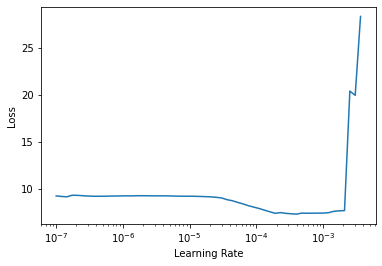

In [15]:
learn.lr_find()

In [17]:
learn.fine_tune(10, 3e-4)

epoch,train_loss,valid_loss,time
0,1.338621,1.231623,00:10


epoch,train_loss,valid_loss,time
0,0.949117,0.623754,00:04
1,0.709892,0.524238,00:04
2,0.590438,0.352810,00:04
3,0.515179,0.282649,00:04
4,0.452689,0.257211,00:04
5,0.406142,0.203727,00:04
6,0.356148,0.174192,00:04
7,0.320793,0.165395,00:04
8,0.287955,0.152181,00:04
9,0.263192,0.151012,00:04


In [46]:
learn.fine_tune(10, 3e-4)

epoch,train_loss,valid_loss,time
0,1.471645,1.170488,00:09


epoch,train_loss,valid_loss,time
0,1.012454,0.598085,00:04
1,0.749190,0.356465,00:04
2,0.601603,0.303624,00:04
3,0.508633,0.282804,00:04
4,0.449279,0.230972,00:04
5,0.402990,0.221252,00:04
6,0.361866,0.195968,00:05
7,0.327366,0.193240,00:05
8,0.300898,0.156310,00:05
9,0.278628,0.156241,00:04


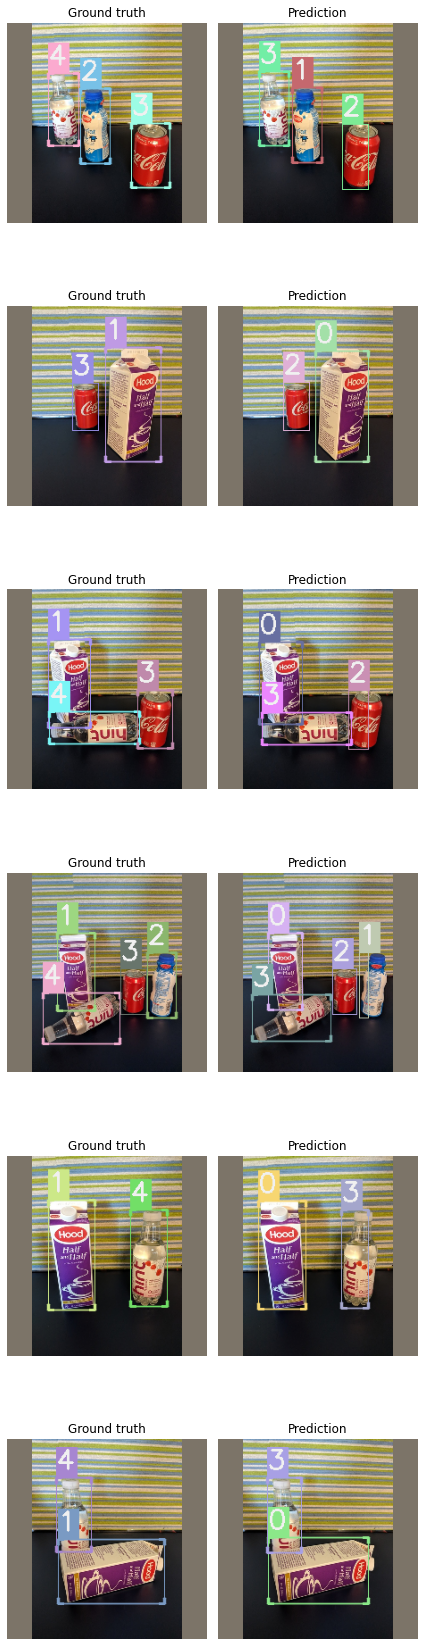

In [19]:
model_type.show_results(model, valid_ds)

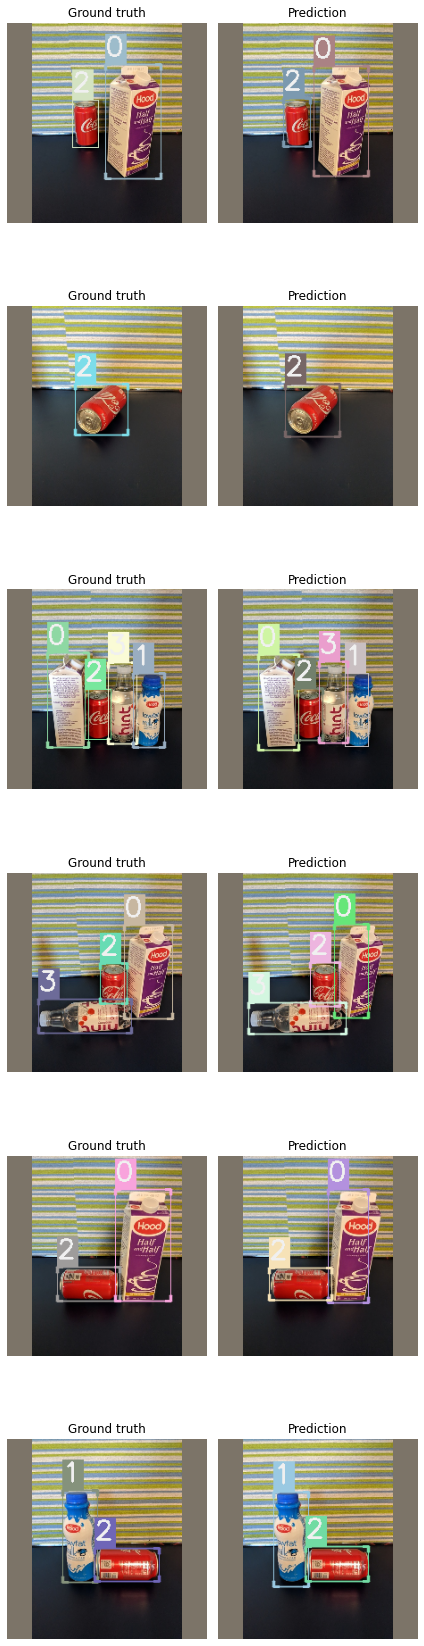

In [48]:
model_type.show_results(model, valid_ds, detection_threshold=.5)

In [16]:
class LitModel(model_type.lightning.ModelAdapter):
    def configure_optimizers(self):
        return Adam(self.parameters(), lr=1e-4)
    
lit_model = LitModel(model)
trainer = pl.Trainer(max_epochs=10, gpus=1, num_sanity_val_steps=0, check_val_every_n_epoch=1)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [15]:
lr_finder = trainer.tuner.lr_find(lit_model, train_dl, valid_dl)


  | Name  | Type       | Params
-------------------------------------
0 | model | FasterRCNN | 41.4 M
-------------------------------------
41.1 M    Trainable params
225 K     Non-trainable params
41.4 M    Total params
/home/lgvaz/miniconda3/envs/mmlab/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/lgvaz/miniconda3/envs/mmlab/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
 

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early due to diverging loss.
Restored states from the checkpoint file at /home/lgvaz/git/icevision/notebooks/lr_find_temp_model.ckpt


/home/lgvaz/miniconda3/envs/mmlab/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


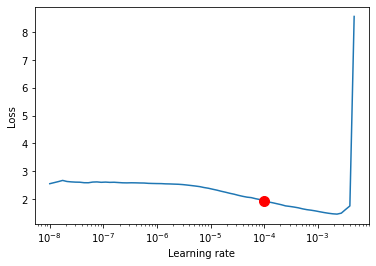

In [16]:
fig = lr_finder.plot(suggest=True)
fig.show()

In [17]:
trainer.fit(lit_model, train_dl, valid_dl)


  | Name  | Type      | Params
------------------------------------
0 | model | RetinaNet | 36.4 M
------------------------------------
36.2 M    Trainable params
225 K     Non-trainable params
36.4 M    Total params


Training: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

1